<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Setup

In [ ]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [ ]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1330, 1920])


tensor([[[225, 225, 225, 225],
         [225, 225, 225, 225],
         [225, 225, 225, 225]],

        [[228, 228, 228, 228],
         [228, 228, 228, 228],
         [228, 228, 228, 228]]], dtype=torch.uint8)

In [ ]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [ ]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 216, 32400)

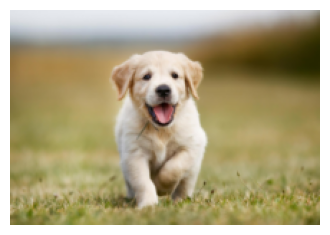

In [ ]:
show_img(img2)

## RGB -> Grey

### Basic Python

In [ ]:
def rgb2grey_py(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]
    return res.view(h,w)

In [ ]:
img_g = rgb2grey_py(img2)

CPU times: user 1.59 s, sys: 27.1 ms, total: 1.61 s
Wall time: 1.11 s


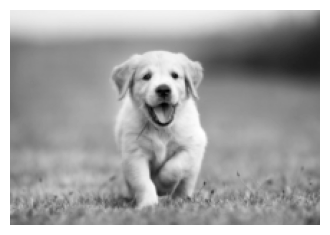

In [ ]:
show_img(img_g, cmap='gray')

### Python Kernel

In [ ]:
def run_kernel(f, times, *args):
    for i in range(times): f(i, *args)

NB: A kernel can not return anything. It can only change contents of things passed to it.

In [ ]:
def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [ ]:
def rgb2grey_pyk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h*w, x, res, n)
    return res.view(h,w)

In [ ]:
img_g = rgb2grey_pyk(img2)

CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.06 s


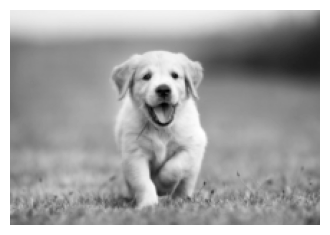

In [ ]:
show_img(img_g, cmap='gray')

### Python Block Kernel

1. **Streaming Multiprocessors (SMs):** In NVIDIA GPUs, SMs are the fundamental units of execution. Each SM can execute multiple threads concurrently.
2. **Thread Blocks:** A thread block is a group of threads that can cooperate among themselves through shared memory and synchronization. All threads in a block are executed on the same SM. This means they can share resources such as shared memory and can synchronize their execution with each other.
3. **Shared Memory:** Shared memory is a small memory space on the GPU that is shared among the threads in a block. It is much faster than global memory (the main GPU memory), but it is also limited in size. Threads in the same block can use shared memory to share data with each other efficiently.

- The RTX 3090, based on the Ampere architecture, has 82 SMs.
- Each SM in GA10x GPUs contain 128 CUDA Cores, four third-generation Tensor Cores, a 256 KB Register File, and 128 KB of L1/Shared Memory
- In CUDA, all threads in a block have the potential to run concurrently. However, the actual concurrency depends on the number of CUDA cores per SM and the resources required by the threads.

In [ ]:
128*82

10496

In [ ]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): f(i, j, threads, *args)

In [ ]:
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx
    if i<n: out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [ ]:
def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)

In [ ]:
img_g = rgb2grey_pybk(img2)

CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.1 s


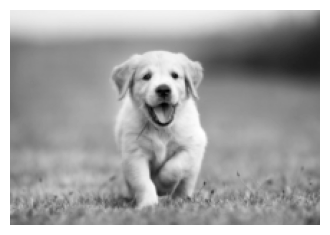

In [ ]:
show_img(img_g, cmap='gray')

### CUDA Setup

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [ ]:
os.environ['CUDA_HOME']='/usr/local/cuda'

In [ ]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [ ]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

### CUDA kernel

- 2^31 max blocks for dim 0, 2^16 max for dims 1 & 2
- 1024 max threads per block (use a multiple of 32)

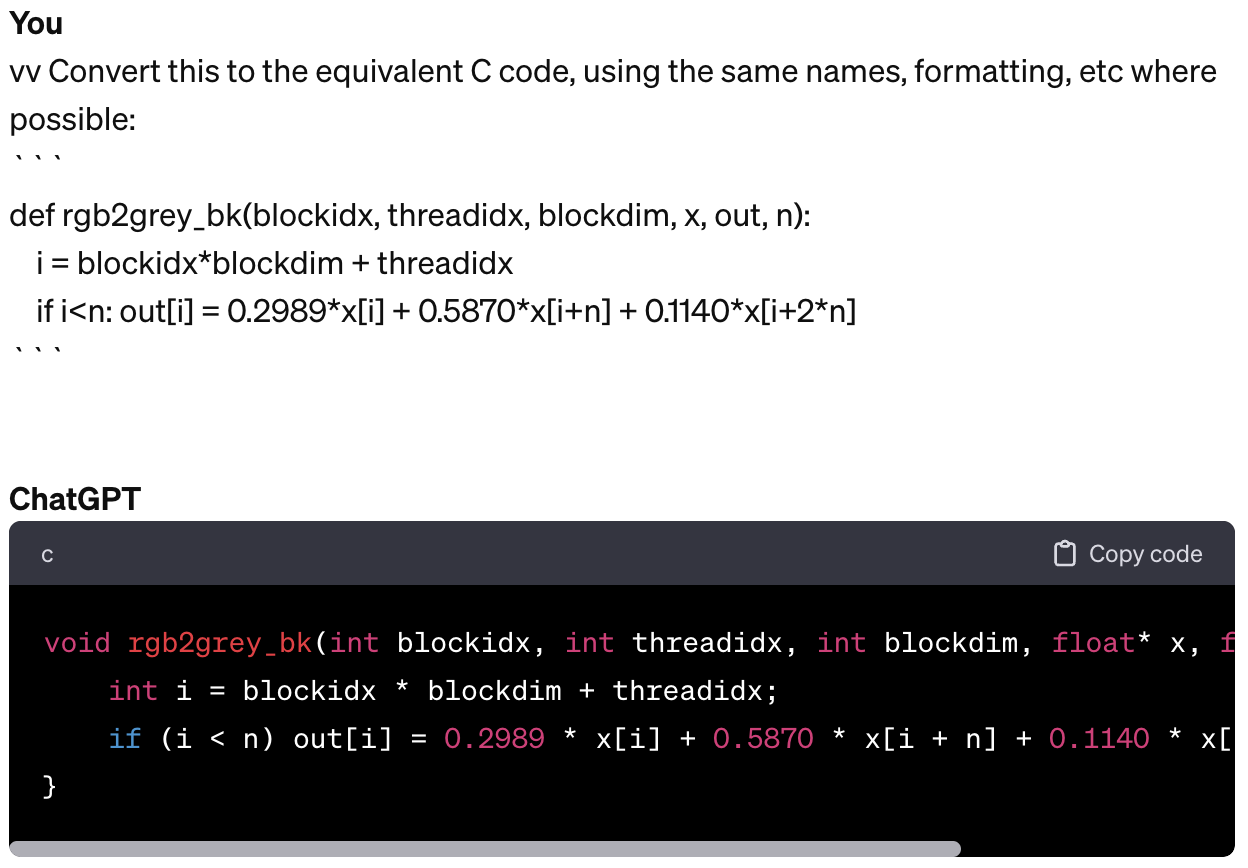

In [ ]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [ ]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [ ]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /home/ben/.cache/torch_extensions/py311_cu118 as PyTorch extensions root...
No modifications detected for re-loaded extension module inline_ext, skipping build step...
Loading extension module inline_ext...


ImportError: /home/ben/.cache/torch_extensions/py311_cu118/inline_ext/inline_ext.so: cannot open shared object file: No such file or directory

In [ ]:
[o for o in dir(module) if o[0]!='_']

In [ ]:
imgc = img.contiguous().cuda()

In [ ]:
res = module.rgb_to_grayscale(imgc).cpu()
h,w = res.shape
h,w,h*w

In [ ]:
show_img(res, cmap='gray')

## Matmul

### Get data

In [ ]:
import gzip,pickle
from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor

In [ ]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [ ]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape,x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [ ]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

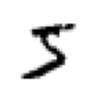

In [ ]:
show_img(imgs[0], cmap='gray_r', figsize=(1,1))

In [ ]:
torch.manual_seed(1)
weights = torch.randn(784,10)
weights

tensor([[-1.5256, -0.7502, -0.6540,  ..., -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  ..., -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  ..., -1.4465,  0.0612, -0.6177],
        ...,
        [ 0.5063,  0.4656, -0.2634,  ...,  0.6452,  0.4298, -1.2936],
        [ 0.5171,  1.0315,  0.8120,  ..., -0.1046,  2.2588, -0.2793],
        [-1.4899,  0.3898, -0.5454,  ..., -0.1923, -0.5076,  0.5439]])

### Python matmul

In [ ]:
m1 = x_valid[:5]
m2 = weights
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

In [ ]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [ ]:
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

In [ ]:
t1.shape

torch.Size([5, 10])

In [ ]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [ ]:
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

CPU times: user 603 ms, sys: 0 ns, total: 603 ms
Wall time: 603 ms


In [ ]:
ar*bc*ac

39200

### 2d Python kernel

In [ ]:
from types import SimpleNamespace as ns

In [ ]:
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x): f(ns(x=i1,y=i0), ns(x=j1,y=j0), threads, *args)

In [ ]:
def matmul_bk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
    r = blockidx.y*blockdim.y + threadidx.y
    c = blockidx.x*blockdim.x + threadidx.x
    
    if (r>=h or c>=w): return
    o = 0.
    for i in range(k): o += m[r*k+i] * n[i*w+c]
    out[r*w+c] = o

In [ ]:
def matmul_2d(m, n):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = ns(x=16,y=16)
    blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))
    blk_kernel2d(matmul_bk, blocks, tpb,
                 m.flatten(), n.flatten(), output.flatten(), h, w, k)
    return output

In [ ]:
res = matmul_2d(m1, m2)
torch.isclose(t1, res).all()

tensor(True)

### Broadcasting

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): c[i] = (a[i,:,None] * b).sum(dim=0)
    return c

In [ ]:
torch.isclose(t1,matmul(m1, m2)).all()

tensor(True)

CPU times: user 1.84 ms, sys: 286 µs, total: 2.13 ms
Wall time: 1.79 ms


In [ ]:
m1 = x_train
tr = matmul(m1, m2)
tr.shape

torch.Size([50000, 10])

CPU times: user 2.33 s, sys: 11.2 ms, total: 2.34 s
Wall time: 1.32 s


In [ ]:
ar,ac = m1.shape
br,bc = m2.shape
ar*bc*ac

392000000

### CUDA matmul

In [ ]:
cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [ ]:
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [ ]:
module = load_cuda(cuda_src, cpp_src, ['matmul'])

OSError: CUDA_HOME environment variable is not set. Please set it to your CUDA install root.

In [ ]:
m1c,m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

In [ ]:
torch.isclose(tr,module.matmul(m1c, m2c).cpu(), atol=1e-5).all()

NameError: name 'module' is not defined

In [ ]:
res=module.matmul(m1c, m2c).cpu()
res.shape

NameError: name 'module' is not defined

### Pytorch

In [ ]:
torch.isclose(tr,(m1c@m2c).cpu(), atol=1e-5).all()

tensor(True)

The slowest run took 11.09 times longer than the fastest. This could mean that an intermediate result is being cached.
5.98 ms ± 7.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### RGB->Grey CUDA 3d

In [ ]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int w, int h) {
    int c = blockIdx.x*blockDim.x + threadIdx.x;
    int r = blockIdx.y*blockDim.y + threadIdx.y;

    if (c<w && r<h) {
        int i = r*w + c;
        int n = h*w;
        out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    torch::Tensor output = torch::empty({h,w}, input.options());
    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    rgb_to_grayscale_kernel<<<blocks, tpb>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w, h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [ ]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

OSError: CUDA_HOME environment variable is not set. Please set it to your CUDA install root.

In [ ]:
res = module.rgb_to_grayscale(imgc).cpu()
show_img(res, cmap='gray')

NameError: name 'module' is not defined